# Modelos de Clustering

O agrupamento é uma técnica de aprendizado não supervisionado que visa encontrar grupos de dados similares. O objetivo é minimizar a diferenciação intra-grupo e maximizar a diferenciação inter-grupo. Os grupos podem ser usados diretamente e analisados ou podem ser usados em técnicas de aprendizado supervisionado como uma nova variável.

In [165]:
import polars as pl
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import silhouette_score, adjusted_rand_score

## Importando e conhecendo os dados

In [8]:
df = pl.read_csv('data/mall.csv')
df.sample(5)

CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
i64,str,i64,i64,i64
127,"""Male""",43,71,35
183,"""Male""",46,98,15
163,"""Male""",19,81,5
195,"""Female""",47,120,16
160,"""Female""",30,78,73


In [9]:
df.shape

(200, 5)

## Explorando os dados

In [10]:
df.describe()

describe,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
str,f64,str,f64,f64,f64
"""count""",200.0,"""200""",200.0,200.0,200.0
"""null_count""",0.0,"""0""",0.0,0.0,0.0
"""mean""",100.5,null,38.85,60.56,50.2
"""std""",57.879185,null,13.969007,26.264721,25.823522
"""min""",1.0,"""Female""",18.0,15.0,1.0
"""25%""",51.0,null,29.0,42.0,35.0
"""50%""",101.0,null,36.0,62.0,50.0
"""75%""",151.0,null,49.0,78.0,73.0
"""max""",200.0,"""Male""",70.0,137.0,99.0


In [12]:
df.select('Gender').to_series().value_counts()

Gender,counts
str,u32
"""Male""",88
"""Female""",112


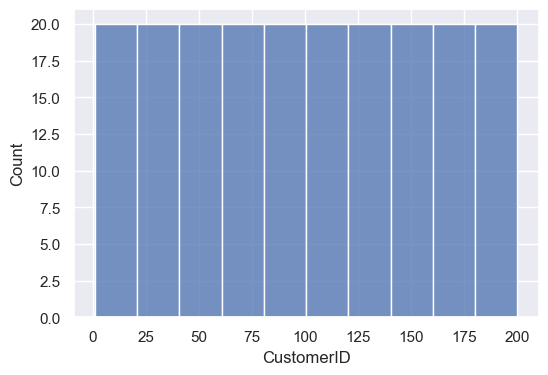

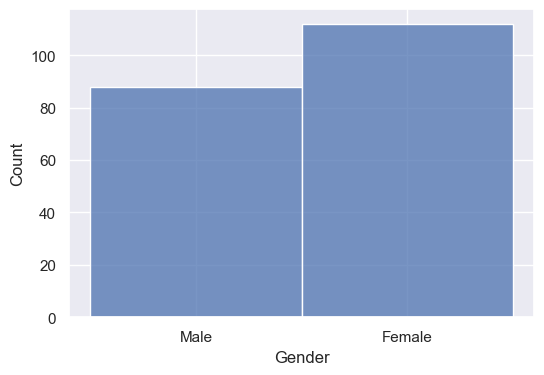

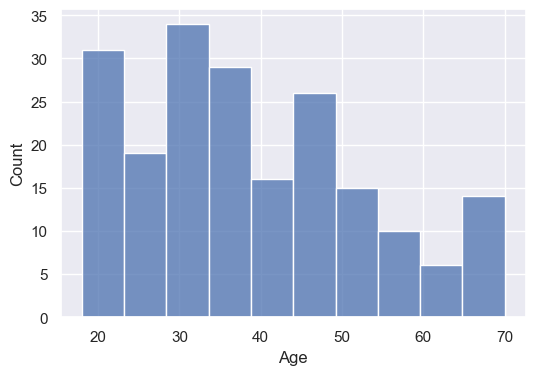

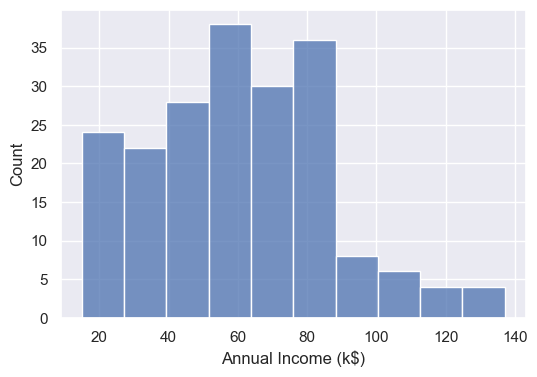

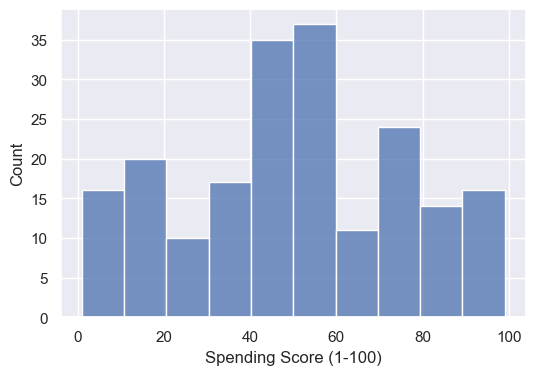

In [24]:
sns.set_theme(style="darkgrid")
for col in df.columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(df, x=col, bins=10)

<Axes: ylabel='col'>

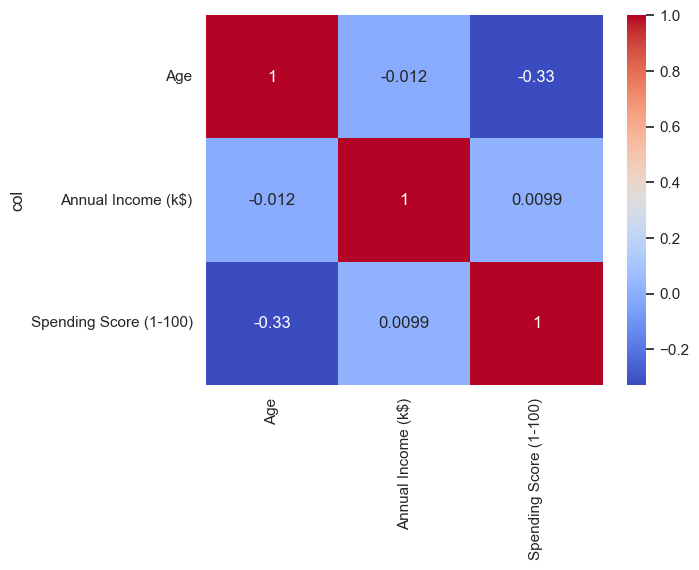

In [29]:
df_aux = df.select(pl.col([pl.Int64, pl.Float64]).exclude('CustomerID'))
df_corr = df_aux.corr().insert_at_idx(0, pl.Series('col', df_aux.columns))

sns.heatmap(
    df_corr.to_pandas().set_index('col'), 
    annot=True, 
    cmap='coolwarm'
)

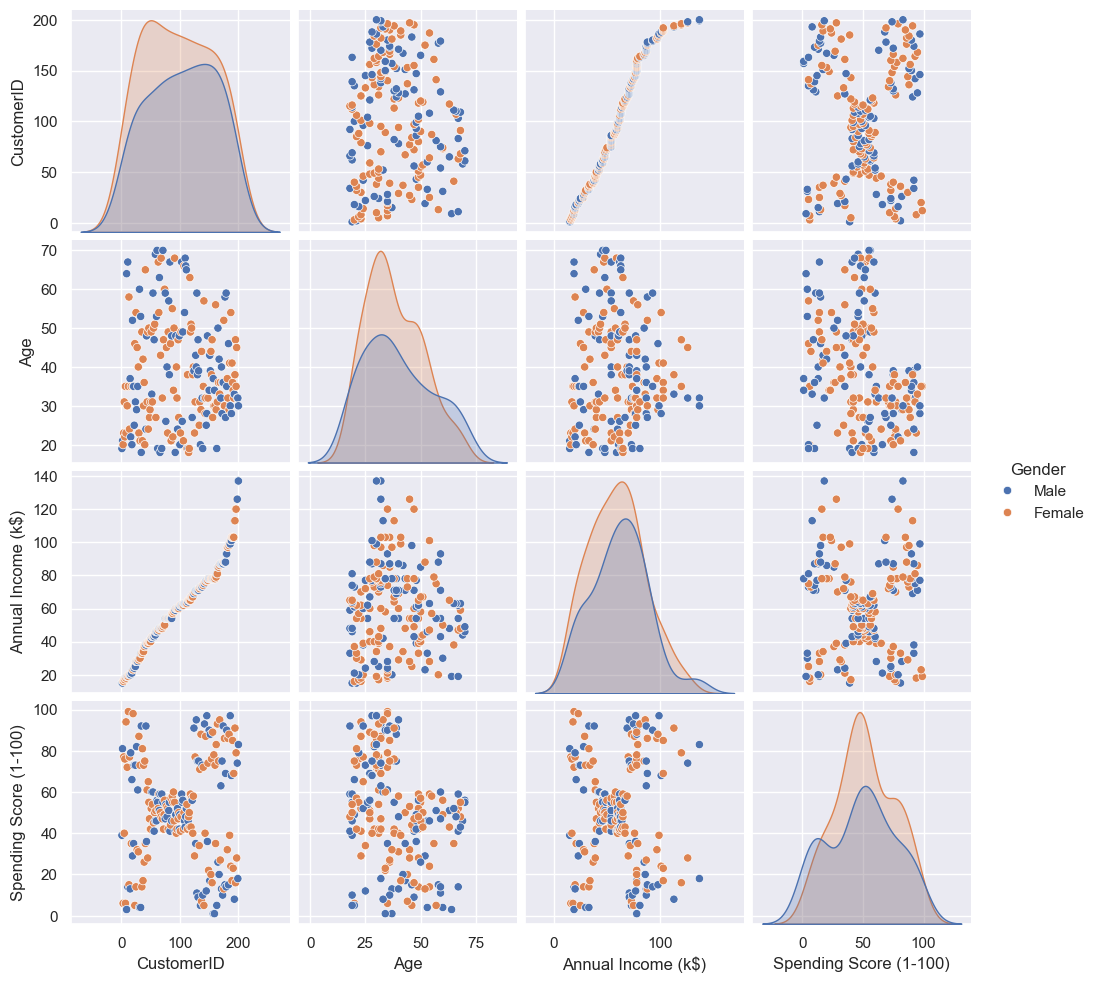

In [31]:
sns.pairplot(df.to_pandas(), hue='Gender')

## Pré-processamento

In [60]:
scaler = StandardScaler()
scaler.fit(df.select(pl.col(['Annual Income (k$)', 'Spending Score (1-100)'])))

df_scaled = scaler.transform(df.select(pl.col(['Annual Income (k$)', 'Spending Score (1-100)'])))

In [61]:
df_noscaled = df.select(pl.col(['Annual Income (k$)', 'Spending Score (1-100)']))

## Modelos de Clustering

Vamos utilizar alguns modelos de clustering para agrupar os dados.

### K-Means

O K-Means é um dos algoritmos de clustering mais populares. Ele é um algoritmo iterativo que tenta particionar o conjunto de dados em K grupos (clusters) distintos, onde cada observação pertence a apenas um grupo. Ele tenta fazer com que a variância intra-cluster seja mínima e a variância inter-cluster seja máxima.

In [115]:
kmeans = KMeans(n_clusters=6, n_init=10, random_state=0)
kmeans.fit(df_noscaled)

centroides = kmeans.cluster_centers_
labels = kmeans.labels_

Vamos executar com os dados normalizados para ver se há diferença.

In [116]:
kmeans_scaled = KMeans(n_clusters=6, n_init=10, random_state=0)
kmeans_scaled.fit(df_scaled)

centroides_scaled = kmeans_scaled.cluster_centers_
labels_scaled = kmeans_scaled.labels_

In [117]:
df_clusters_scaled = pl.DataFrame(df_scaled, schema=['Annual Income (k$)', 'Spending Score (1-100)'])
df_clusters_scaled = df_clusters_scaled.with_columns(
    pl.Series(labels_scaled).alias('cluster')
)
df_clusters_scaled.sample(5)

Annual Income (k$),Spending Score (1-100),cluster
f64,f64,i32
0.093133,-0.163051,5
0.093133,-0.085407,5
1.0092,-0.90066,1
-0.899272,0.962775,3
-1.586321,1.894492,3


In [118]:
df_clusters_noscaled = df_noscaled.with_columns(
    pl.Series(labels).alias('cluster')
)
df_clusters_noscaled.sample(5)

Annual Income (k$),Spending Score (1-100),cluster
i64,i64,i32
78,73,1
63,46,3
103,85,4
48,59,3
78,1,2


Vamos agora analisar os grupos e os centroides.

In [119]:
pl.Series(labels).value_counts()

,counts
i32,u32
0,22
3,81
4,11
1,28
2,35
5,23


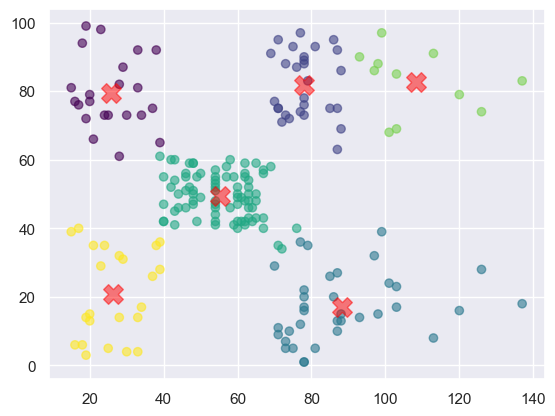

In [120]:
plt.scatter(
    df_clusters_noscaled['Annual Income (k$)'], 
    df_clusters_noscaled['Spending Score (1-100)'], 
    c=df_clusters_noscaled['cluster'],
    cmap='viridis',
    alpha=0.6
)

plt.scatter(centroides[:, 0], centroides[:, 1], c='red', marker='X', s=200, alpha=0.5);

In [121]:
pl.Series(labels_scaled).value_counts()

,counts
i32,u32
0,23
2,28
4,11
1,36
5,80
3,22


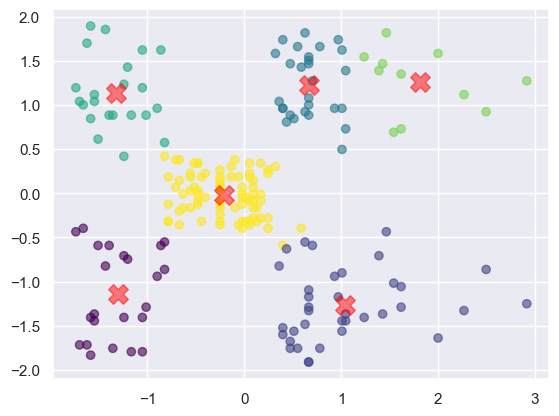

In [122]:
plt.scatter(
    df_clusters_scaled['Annual Income (k$)'], 
    df_clusters_scaled['Spending Score (1-100)'], 
    c=df_clusters_scaled['cluster'],
    cmap='viridis',
    alpha=0.6
)

plt.scatter(centroides_scaled[:, 0], centroides_scaled[:, 1], c='red', marker='X', s=200, alpha=0.5);


Percebemos que não há diferença entre os grupos com os dados normalizados e sem normalizar.

In [128]:
df_cluster = df.with_columns(
    pl.Series(labels).alias('cluster')
)

#### Método do cotovelo (Elbow Method)

O método do cotovelo é uma técnica utilizada para encontrar o número ideal de clusters em um conjunto de dados. Ele consiste em executar o algoritmo K-Means variando o número de clusters e plotar o valor da função de custo (SSE) para cada valor de K. O valor de K a partir do qual o valor da função de custo não diminui significativamente é escolhido como o número de clusters.

O valor da função de custo é calculado como a soma das distâncias quadradas entre cada membro do cluster e seu centróide. Quanto menor o valor da função de custo, mais compacto é o cluster.

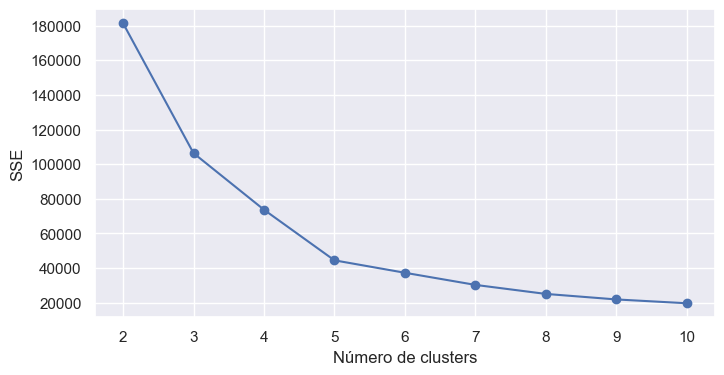

In [124]:
k = list(range(2, 11))
sse = []

for i in k:
    kmeans = KMeans(n_clusters=i, n_init=10, random_state=0)
    kmeans.fit(df_noscaled)
    sse.append(kmeans.inertia_)

plt.rcParams['figure.figsize'] = (8, 4)
plt.plot(k, sse, '-o')
plt.xlabel('Número de clusters')
plt.ylabel('SSE');
plt.show()

In [132]:
df_cluster.group_by('cluster').agg(pl.mean('Age')).sort('cluster')

cluster,Age
i32,f64
0,25.272727
1,32.785714
2,41.114286
3,42.716049
4,32.454545
5,45.217391


Vamos treinar o Kmeans com 5 grupos

In [151]:
kmeans = KMeans(n_clusters=5, n_init=10, random_state=0)
kmeans.fit(df_noscaled)

centroides = kmeans.cluster_centers_
labels = kmeans.labels_

df_cluster = df.with_columns(
    pl.Series(labels).alias('cluster')
)

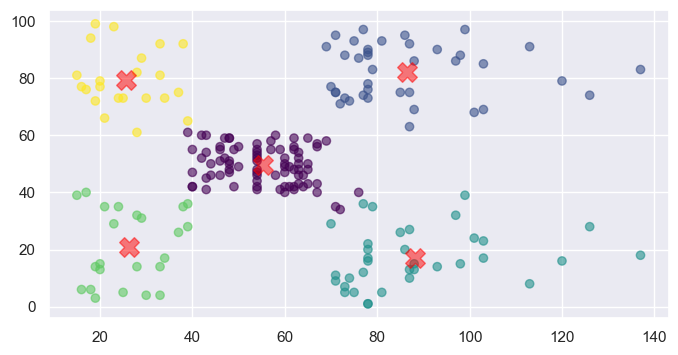

In [152]:
plt.scatter(
    df_cluster['Annual Income (k$)'], 
    df_cluster['Spending Score (1-100)'], 
    c=df_cluster['cluster'],
    cmap='viridis',
    alpha=0.6
)

plt.scatter(centroides[:, 0], centroides[:, 1], c='red', marker='X', s=200, alpha=0.5);

Podemos utilizar o MinMaxScaler para normalizar os dados e visualizar através de um papa de calor. Isso nos permite visualizar a relação entre os dados e os clusters.

<Axes: ylabel='cluster'>

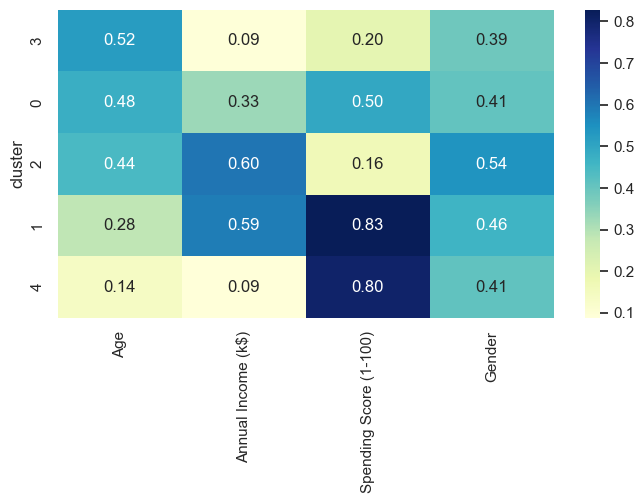

In [153]:
df_temp = df.select(
    pl.all().exclude(['CustomerID', 'Gender']),
    pl.when(pl.col('Gender') == 'Male').then(pl.lit(1)).otherwise(pl.lit(0)).alias('Gender')
)

mms = MinMaxScaler()
mms.fit(df_temp)

df_aux = (
    pl.DataFrame(
        mms.transform(df_temp), 
        schema=df_temp.columns
    )
    .select(
        pl.all(), 
        pl.Series(labels).alias('cluster')
    )
)

df_aux = df_aux.group_by('cluster').agg(pl.all().mean())

sns.heatmap(
    df_aux.to_pandas().set_index('cluster'), 
    annot=True, 
    cmap='YlGnBu',
    fmt='.2f'
)

Podemos ver que no Cluster 3 ficou os clientes com menos Spending Score e menor Renda Anual, já o cluster 1 temos os clientes com maior Renda Anual e maior Spending Score.

### DBSCAN

O DBSCAN é um algoritmo de clustering que agrupa pontos próximos uns dos outros com base em uma distância específica. Ele agrupa os pontos em dois grupos: pontos de dados densos (que estão dentro de um raio especificado) e pontos de dados não densos (que não estão dentro do raio especificado).

In [155]:
dbscan = DBSCAN(eps=10, min_samples=8)
dbscan.fit(df_noscaled)

dbscan_labels = dbscan.labels_
dbscan_labels

array([-1,  0,  1,  0, -1,  0,  1, -1,  1,  0, -1, -1, -1,  0,  1,  0, -1,
        0, -1, -1, -1,  0,  1,  0,  1,  0, -1, -1,  2,  0,  1,  0,  1, -1,
       -1,  0, -1,  0,  2, -1,  2, -1,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  3,  2,  3,  2,  3,  4,  3,  4,  3,  2,  3,  4,  3,
        4,  3,  4,  3,  4,  3,  2,  3,  4,  3,  2,  3,  4,  3,  4,  3,  4,
        3,  4,  3,  4,  3,  4,  3,  2,  3,  4,  3,  4,  3,  4,  3,  4, -1,
        4,  3,  4,  3,  4,  3,  4,  3,  4,  3, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

Os clusters classificados como -1 são os outliers.

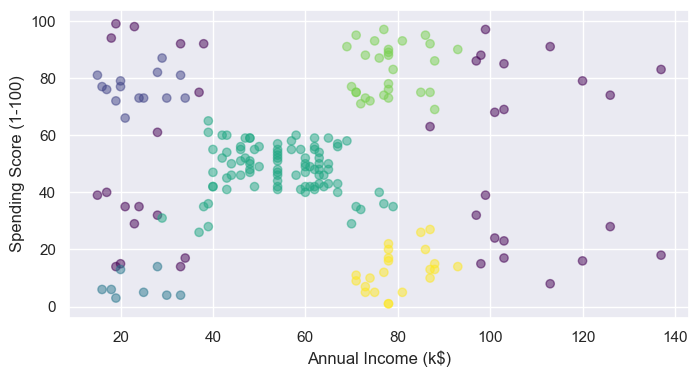

In [158]:
plt.scatter(
    df_noscaled['Annual Income (k$)'], 
    df_noscaled['Spending Score (1-100)'], 
    c=dbscan_labels,
    cmap='viridis',
    alpha=0.5
)
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)');
plt.show()

Vamos remover os outliers e visualizar os dados.

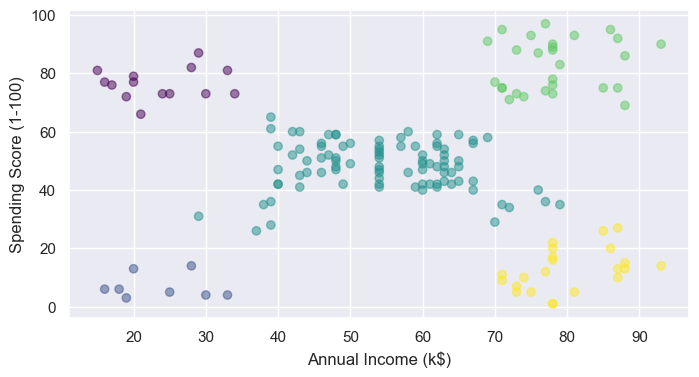

In [159]:
df_aux = df_noscaled.with_columns(
    pl.Series(dbscan_labels).alias('cluster')
).filter(
    pl.col('cluster') != -1
)

plt.scatter(
    df_aux['Annual Income (k$)'], 
    df_aux['Spending Score (1-100)'], 
    c=df_aux['cluster'],
    cmap='viridis',
    alpha=0.5
)
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)');
plt.show()

## Como validar uma clusterização?


Em modelos não supervisionados, não temos a separação dos dados em treino e teste, isso porque nos modelos supervisionados queremos buscar uma relação entre os dados existentes e encontrar uma similaridade que possa distinguir grupos.

- Interna: Quanto bom foi o meu agrupamento?
- Externa: O quão parecido estão os meus dois algoritmos?


### Tipo Externo - Usando o Adjusted Rand Index (ARI)

O ARI é uma medida de similaridade entre dois agrupamentos. Ele retorna um valor entre 0 e 1, onde 1 significa que os agrupamentos são idênticos e 0 significa que os agrupamentos são independentes (diferentes).


In [160]:
adjusted_rand_score(labels, dbscan_labels)

0.7151933782093212

### Tipo Interno - Usando a métrica de Silhouette

A métrica de Silhouette é uma medida de similaridade entre um objeto e seu próprio cluster (coesão) em comparação com outros clusters (separação). Ela varia de -1 a 1, onde um valor mais alto indica que o objeto está melhor ajustado ao seu próprio cluster e pior ajustado aos clusters vizinhos.

#### K-Means


In [161]:
silhouette_score(df_noscaled, labels)

0.553931997444648

#### DBSCAN

In [162]:
silhouette_score(df_noscaled, dbscan_labels)

0.36328873885121793

## Segmentação de Imagens de Câncer de Mama

Vamos usar o dataset mini-MIAS (Mammographic Image Analysis Society) para segmentar imagens de câncer de mama. O dataset contém 322 imagens de câncer de mama digitalizadas de 161 pacientes. Cada imagem é classificada como benigna ou maligna.

O dataset pode ser baixado em: https://www.kaggle.com/kmader/mias-mammography ou http://peipa.essex.ac.uk/info/mias.html

In [164]:
# Bibliotecas necessárias para análise de imagens
from PIL import Image
import glob

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Vamos carregar as imagens e em seguida visualiza-las

In [167]:
img_G = mpimg.imread('data/mdb001.pgm')
img_D = mpimg.imread('data/mdb003.pgm')
img_F = mpimg.imread('data/mdb005.pgm')

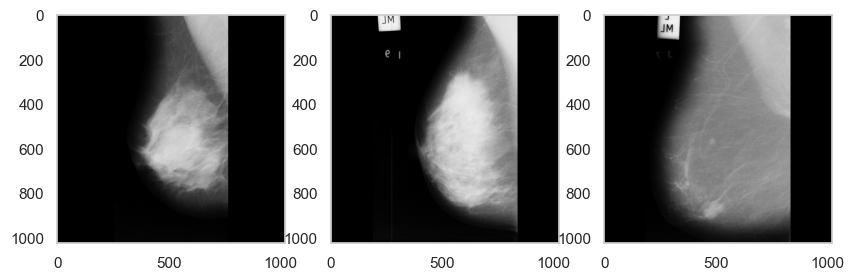

In [175]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))

axs[0].grid(False)
axs[1].grid(False)
axs[2].grid(False)

img1 = axs[0].imshow(img_G, cmap='gray', vmin=0, vmax=255)
img2 = axs[1].imshow(img_D, cmap='gray', vmin=0, vmax=255)
img3 = axs[2].imshow(img_F, cmap='gray', vmin=0, vmax=255)

plt.show()

Vamos criar uma função para segmentar as imagens

In [181]:
def filtro_kmeans(img, clusters):
    vectorized = img.reshape((-1, 1))
    kmeans = KMeans(n_clusters=clusters, random_state=0, n_init = 5)
    kmeans.fit(vectorized)

    centers = np.uint8(kmeans.cluster_centers_)
    segmented_data = centers[kmeans.labels_.flatten()]

    segmented_image = segmented_data.reshape(img.shape)
    return segmented_image

In [182]:
clusters = 3

img_G_seg = filtro_kmeans(img_G, clusters)
img_D_seg = filtro_kmeans(img_D, clusters)
img_F_seg = filtro_kmeans(img_F, clusters)


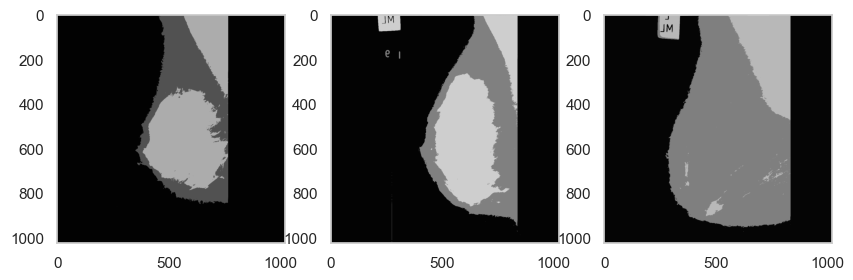

In [184]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))

axs[0].grid(False)
axs[1].grid(False)
axs[2].grid(False)

img1 = axs[0].imshow(img_G_seg, cmap='gray', vmin=0, vmax=255)
img2 = axs[1].imshow(img_D_seg, cmap='gray', vmin=0, vmax=255)
img3 = axs[2].imshow(img_F_seg, cmap='gray', vmin=0, vmax=255)

plt.show()

Para mais detalhes sobre o algoritmo de segmentação, acesse: https://experiencor.github.io/segmentation.html